In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dataframe_image as dfi
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
import math
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [87]:
# 1. Memuat data
df = pd.read_csv('../Resource/address_dataset_kaggle.csv', index_col=0)
print(f"Shape of data: {df.shape}")

Shape of data: (9841, 50)


In [88]:
# 2. Analisis Data
def analysis(df):
    total_null = df.isnull().sum().sum()
    print(f"Jumlah data kosong: {total_null}")
    print("-" * 50)
    total_duplicate = df.duplicated().sum()
    print(f"Jumlah data duplikat: {total_duplicate}")
    print("-" * 50)
    df.info()
    print("-" * 50)

analysis(df)


Jumlah data kosong: 22635
--------------------------------------------------
Jumlah data duplikat: 0
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 50 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Index                                                 9841 non-null   int64  
 1   Address                                               9841 non-null   object 
 2   FLAG                                                  9841 non-null   int64  
 3   Avg min between sent tnx                              9841 non-null   float64
 4   Avg min between received tnx                          9841 non-null   float64
 5   Time Diff between first and last (Mins)               9841 non-null   float64
 6   Sent tnx                                              9841 non-null   int64  

In [89]:
# 3. Data Cleaning
columns_drop = ['Index', 'Address'] 
df = df.drop(columns=columns_drop)

In [90]:
#4 Imputasi nilai
# untuk kolom numerik (mean)
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
num_imputer = SimpleImputer(strategy='mean')
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Imputasi untuk kolom kategorikal (modus)
cat_cols = df.select_dtypes(include=['object']).columns
cat_imputer = SimpleImputer(strategy='most_frequent')
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

In [91]:
# 5. Split data terlebih dahulu
X = df.drop(columns=['FLAG'])
y = df['FLAG'].values.ravel()
X.columns = X.columns.str.replace(' ', '_')

In [92]:
#6 Encoding data kategorikal
# List kolom kategorikal
categorical_columns = ['_ERC20_most_sent_token_type', '_ERC20_most_rec_token_type']

# Inisialisasi LabelEncoder
le = LabelEncoder()

# Iterasi dan transformasi tiap kolom
for col in categorical_columns:
    X[col] = le.fit_transform(X[col].astype(str)) 

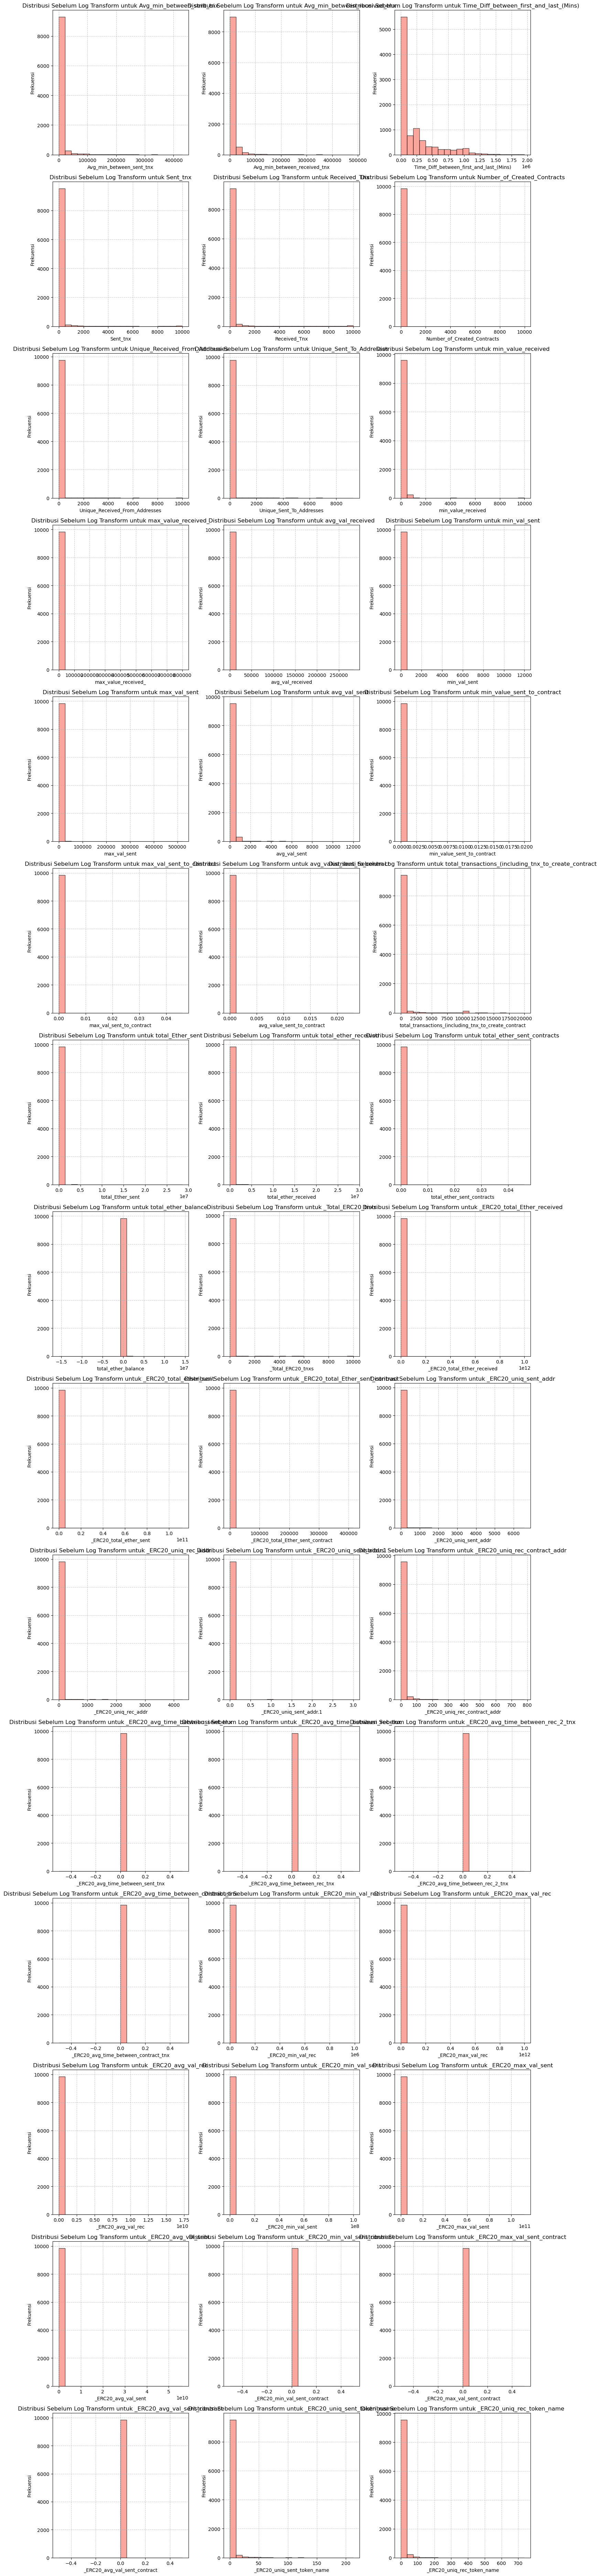

In [93]:
# Visualisasi data sebelum dilakukan transformasi
num_cols_in_X = X.select_dtypes(include=['float64', 'int64']).columns
n_plots = len(num_cols_in_X)
n_rows = math.ceil(n_plots / 3)

plt.figure(figsize=(15, 5 * n_rows))
for idx, col in enumerate(num_cols_in_X, 1):
    plt.subplot(n_rows, 3, idx)
    plt.hist(X[col], bins=20, alpha=0.7, color='salmon', edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(f'Distribusi Sebelum Log Transform untuk {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

In [94]:
# 7. Log-transformasi untuk fitur numerik
X_safe = X.copy()
X_safe[num_cols_in_X] = X_safe[num_cols_in_X].apply(lambda col: col.apply(lambda x: x if x > 0 else 0.001))

log_transformer = FunctionTransformer(np.log1p, validate=True)
X_log = log_transformer.fit_transform(X_safe[num_cols_in_X])
X_log = pd.DataFrame(X_log, columns=num_cols_in_X)

# Gabungkan hasil transformasi ke DataFrame X
X[num_cols_in_X] = X_log

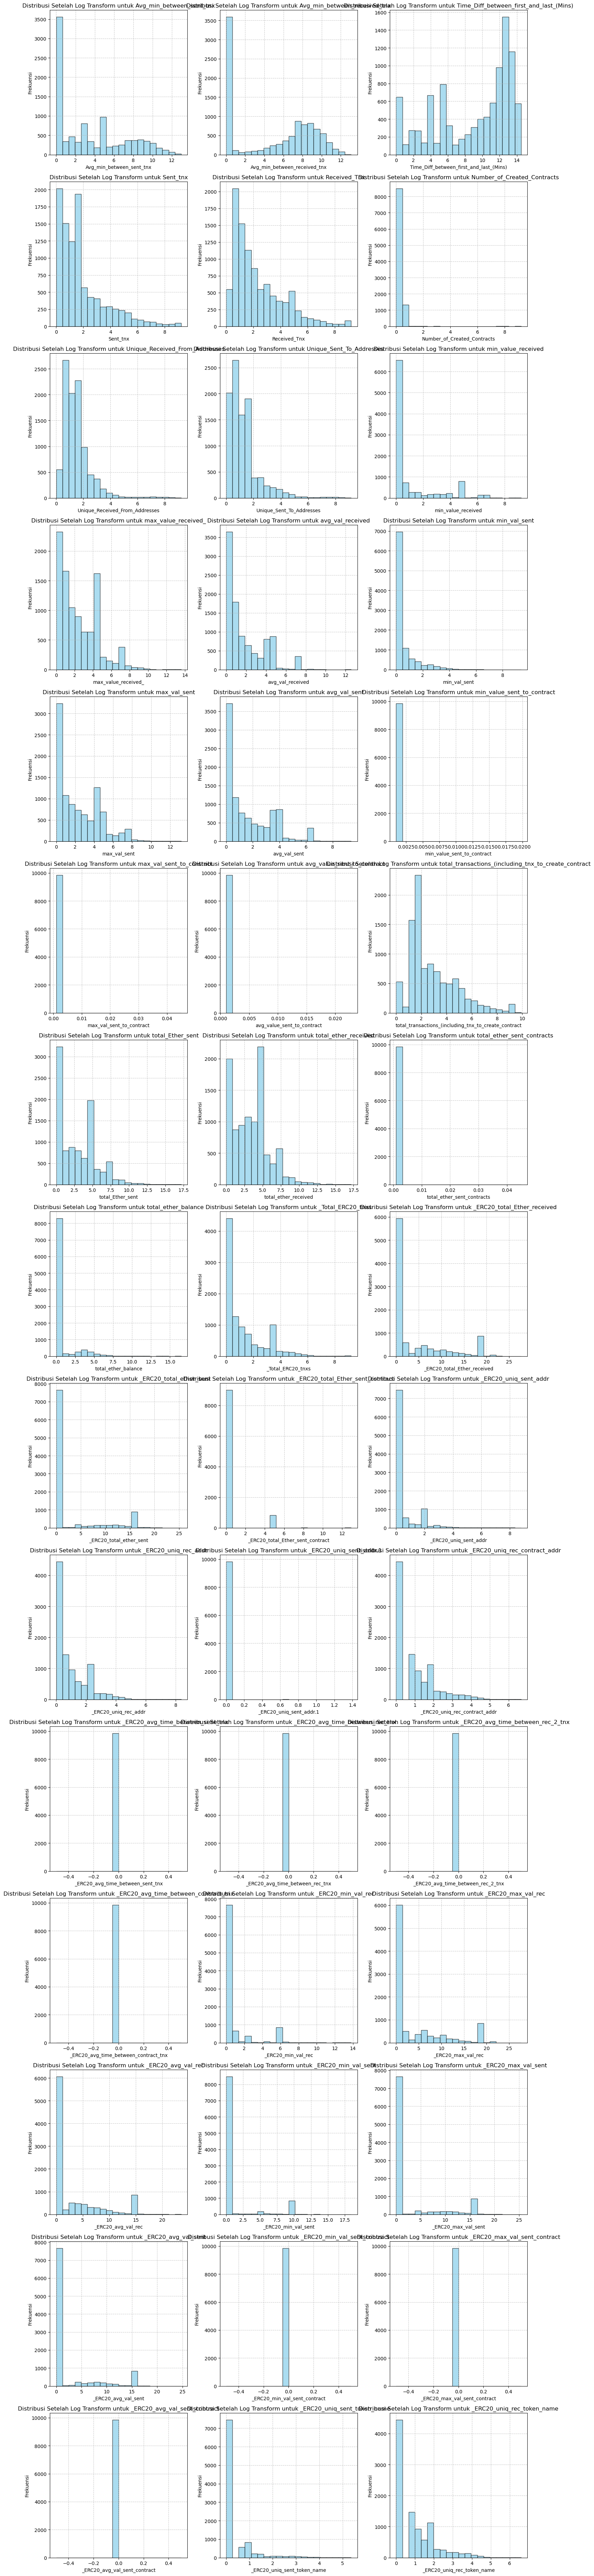

In [95]:
# Visualisasi distribusi setelah log transformasi
plt.figure(figsize=(15, 5 * n_rows))
for idx, col in enumerate(num_cols_in_X, 1):
    plt.subplot(n_rows, 3, idx)
    plt.hist(X[col], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.title(f'Distribusi Setelah Log Transform untuk {col}')
    plt.xlabel(col)
    plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()

In [96]:
# 8. Feature Selection
model = GradientBoostingClassifier(random_state=42)
sfs = SequentialFeatureSelector(
    estimator=model,
    n_features_to_select= 5,
    direction='forward',
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
sfs.fit(X, y)

# Pilih fitur terpilih
selected_features = X.columns[sfs.get_support()]
print("Fitur yang dipilih berdasarkan Sequential Feature Selection:")
for feature in selected_features:
    print(f"- {feature}")

Fitur yang dipilih berdasarkan Sequential Feature Selection:
- Time_Diff_between_first_and_last_(Mins)
- Unique_Received_From_Addresses
- _ERC20_max_val_rec
- _ERC20_most_sent_token_type
- _ERC20_most_rec_token_type


In [97]:
X_selected = X[selected_features]
X_selected.columns

Index(['Time_Diff_between_first_and_last_(Mins)',
       'Unique_Received_From_Addresses', '_ERC20_max_val_rec',
       '_ERC20_most_sent_token_type', '_ERC20_most_rec_token_type'],
      dtype='object')

In [98]:
# 9 Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [99]:
# 10. SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [100]:
# Cek distribusi dengan Counter (tidak membutuhkan tipe int)
print("Distribusi sebelum SMOTE:", Counter(y_train))
print("Distribusi setelah SMOTE:", Counter(y_train_resampled))

Distribusi sebelum SMOTE: Counter({0.0: 6120, 1.0: 1752})
Distribusi setelah SMOTE: Counter({0.0: 6120, 1.0: 6120})


In [101]:
# 11. Simpan data hasil preprocessing
X_train_resampled.to_csv("../n = 5/X_train_smote.csv", index=False)
X_test.to_csv("../n = 5/X_test.csv", index=False)

# Simpan y_train_smote sebagai array 1 dimensi
np.savetxt("../n = 5/y_train_smote.csv", y_train_resampled, delimiter=",", fmt='%d')

# Simpan y_test sebagai array 1 dimensi
np.savetxt("../n = 5/y_test.csv", y_test, delimiter=",", fmt='%d')

print("\nData telah di-export:")
print(f"X_train_smote shape: {X_train_resampled.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train_smote shape: {y_train_resampled.shape}")
print(f"y_test shape: {y_test.shape}")


Data telah di-export:
X_train_smote shape: (12240, 5)
X_test shape: (1969, 5)
y_train_smote shape: (12240,)
y_test shape: (1969,)
